In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Data source
### this data source is derived from publicly available data from the NASA data repository using the Turbofan Engine Degradation Simulation Data Set.

https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan


https://c3.nasa.gov/dashlink/resources/139/

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine – i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:







*   1)	unit number
*   2)	time, in cycles
*   3)	operational setting 1
*   4)	operational setting 2
*   5)	operational setting 3
*   6)	sensor measurement  1
*   7)	sensor measurement  2
*   ...
*   26)	sensor measurement  21


In [3]:
#dataset column names:

col_names = ['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

## training data

In [6]:
#load training data

df_train = pd.read_csv('data/PM_train.txt', sep = ' ', header=None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [7]:

#drop extra space columnn

df_train.drop([26,27], axis=1, inplace=True)

In [8]:
#assign column names

df_train.columns = col_names
df_train

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [9]:
df_train[df_train["id"]==1]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,14.62,...,519.79,2388.23,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588
188,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,...,519.58,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127
189,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,...,520.04,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,...,519.57,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295


##test data

In [11]:
df_test = pd.read_csv('data/PM_test.txt', sep = ' ', header=None)

df_test.drop([26,27], axis=1, inplace=True)
df_test.columns = col_names
df_test

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699



*   id: Engine Id. There are 100 engines. Range 1 - 100
*  cycle: sequence per engine, starts from 1 to the cycle number where failure had happened
*  setting1 to setting3: engine operational settings
*  s1 to s21: sensors measurements in each cycle





## Truth Data

In [13]:
df_truth = pd.read_csv('data/PM_truth.txt', sep = ' ', header=None)

In [14]:
df_truth=df_truth.drop(columns=1)
df_truth = df_truth.rename(columns = {0: 'ttf'}, inplace = False)


In [15]:
df_truth

,ttf
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [16]:
df_truth.reset_index(level=0, inplace=True)
df_truth.columns = ['id', 'ttf']

In [17]:
df_truth['id']=df_truth['id']+1

In [18]:
df_truth

,id,ttf
0,1,112
1,2,98
2,3,69
3,4,82
4,5,91
...,...,...
95,96,137
96,97,82
97,98,59
98,99,117


## prepare_train_data

In [19]:
def prepare_train_data(df_, period):
    df_max_cycle = pd.DataFrame(df_.groupby('id')['cycle'].max())
    df_max_cycle.reset_index(level=0, inplace=True)
    df_max_cycle.columns = ['id', 'last_cycle']

    df_test_in = pd.merge(df_train, df_max_cycle, on='id')
    df_test_in['ttf'] = df_test_in['last_cycle'] - df_test_in['cycle']
    df_test_in=df_test_in.drop(columns="last_cycle")
    #create binary classification label
    df_test_in['label_classification'] = df_test_in['ttf'].apply(lambda x: 1 if x <= period else 0)
    return df_test_in


In [20]:
df_train

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [21]:
period=30

In [22]:
df_train_=prepare_train_data(df_train, period)

In [23]:
df_train_

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_classification
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4,1
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3,1
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2,1
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1,1


## prepare_test_data

In [24]:
def prepare_test_data(df_, df_truth_, period):
  df_test_last_cycle = pd.DataFrame(df_.groupby('id')['cycle'].max())
  df_test_last_cycle.reset_index(level=0, inplace=True)
  df_test_last_cycle.columns = ['id', 'last_cycle']

  df_test_in = pd.merge(df_, df_test_last_cycle, on='id')

  

  df_test_in = df_test_in[df_test_in['cycle'] == df_test_in['last_cycle']]

  df_test_in.drop(['last_cycle'], axis=1, inplace=True)
  
  df_test_in.reset_index(drop=True, inplace=True)




  #df_test_in = pd.concat([df_test_in, df_truth], axis=1)
  df_test_in = pd.merge(df_test_in, df_truth, on='id')





  #create binary classification label
  df_test_in['label_classification'] = df_test_in['ttf'].apply(lambda x: 1 if x <= period else 0)
  return df_test_in


In [ ]:
df_test

In [25]:
df_test_=prepare_test_data(df_test, df_truth, period=30)

In [26]:
df_test_

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_classification
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552,112,0
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618,98,0
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740,69,0
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581,82,0
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117,91,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,97,-0.0006,0.0003,100.0,518.67,642.30,1590.88,1397.94,14.62,...,8148.24,8.4110,0.03,391,2388,100.0,38.96,23.4606,137,0
96,97,134,0.0013,-0.0001,100.0,518.67,642.59,1582.96,1410.92,14.62,...,8155.48,8.4500,0.03,395,2388,100.0,38.61,23.2953,82,0
97,98,121,0.0017,0.0001,100.0,518.67,642.68,1599.51,1415.47,14.62,...,8146.39,8.4235,0.03,394,2388,100.0,38.76,23.3608,59,0
98,99,97,0.0047,-0.0000,100.0,518.67,642.00,1585.03,1397.98,14.62,...,8150.38,8.4003,0.03,391,2388,100.0,38.95,23.3595,117,0


In [ ]:
def add_features(df_in, rol_win_size):
    
 
    sensor_cols = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
    
    sensor_av_cols = [nm.replace('s', 'av') for nm in sensor_cols]
    sensor_sd_cols = [nm.replace('s', 'sd') for nm in sensor_cols]
    
    df_out = pd.DataFrame()
    
    ws = rol_win_size
    
    #calculate rolling stats for each engine id
    
    for m_id in pd.unique(df_in.id):
    
        # get a subset for each engine sensors
        df_engine = df_in[df_in['id'] == m_id]
        df_sub = df_engine[sensor_cols]

    
        # get rolling mean for the subset
        av = df_sub.rolling(ws, min_periods=1).mean()
        av.columns = sensor_av_cols
    
        # get the rolling standard deviation for the subset
        sd = df_sub.rolling(ws, min_periods=1).std().fillna(0)
        sd.columns = sensor_sd_cols
    
        # combine the two new subset dataframes columns to the engine subset
        new_ftrs = pd.concat([df_engine,av,sd], axis=1)
    
        # add the new features rows to the output dataframe
        df_out = pd.concat([df_out,new_ftrs])
        
    return df_out

# data visualization

In [ ]:
df_train_

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_classification
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4,1
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3,1
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2,1
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1,1


In [ ]:
df_train_.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_classification
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.300000e+00,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,107.807862,0.150259
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,0.885092,0.070985,22.082880,4.660829e-13,0.267087,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,68.880990,0.357334
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.300000e+00,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.300000e+00,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000,0.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.300000e+00,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000,0.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.300000e+00,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,155.000000,0.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,361.000000,1.000000


## std

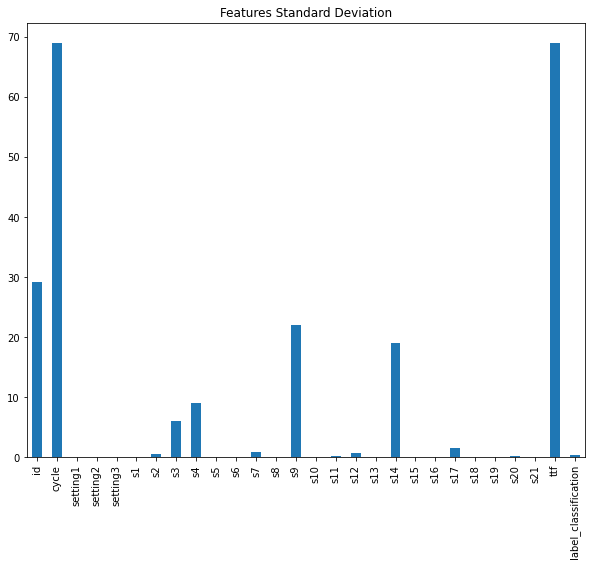

In [ ]:
df_train_.std().plot(kind='bar', figsize=(10,8), title="Features Standard Deviation")

## box plot

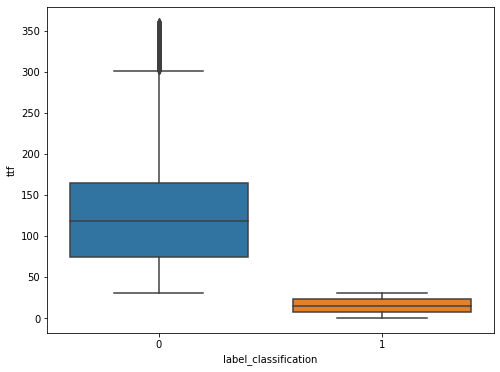

In [ ]:
#box plot overallqual/saleprice
var = 'label_classification'
data = pd.concat([df_train_['ttf'], df_train_[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="ttf", data=data)
#fig.axis(ymin=0, ymax=800000);

## correlation

In [ ]:

# get ordered list features correlation with regression label ttf

df_train_.corrwith(df_train_.ttf).sort_values(ascending=False)

ttf                     1.000000e+00
s12                     6.719831e-01
s7                      6.572227e-01
s21                     6.356620e-01
s20                     6.294285e-01
id                      7.875253e-02
s16                    -3.969701e-16
s5                     -3.969701e-16
setting2               -1.947628e-03
setting1               -3.198458e-03
s6                     -1.283484e-01
s14                    -3.067689e-01
s9                     -3.901016e-01
s13                    -5.625688e-01
s8                     -5.639684e-01
label_classification   -5.665959e-01
s3                     -5.845204e-01
s17                    -6.061536e-01
s2                     -6.064840e-01
s15                    -6.426670e-01
s4                     -6.789482e-01
s11                    -6.962281e-01
cycle                  -7.362406e-01
setting3                         NaN
s1                               NaN
s10                              NaN
s18                              NaN
s

In [ ]:
#These features will be target for removal in feature selection
low_cor_features = ['setting3', 's1', 's10', 's18','s19','s16','s5', 'setting2', 'setting1']

In [ ]:

# list of features having high correlation with regression label ttf

correl_featurs = ['s12', 's7', 's21', 's20', 's6', 's14', 's9', 's13', 's8', 's3', 's17', 's2', 's15', 's4', 's11']

## PCA

In [ ]:
ccx = df_train_.columns
datav = np.array(df_train_[['s12', 's7', 's21', 's20', 's6', 's14', 's9', 's13', 's8', 's3', 's17', 's2', 's15', 's4', 's11',"ttf"]])

In [ ]:
pip install git+git://github.com/rasbt/mlxtend.git

In [ ]:
from mlxtend.plotting import plot_pca_correlation_graph

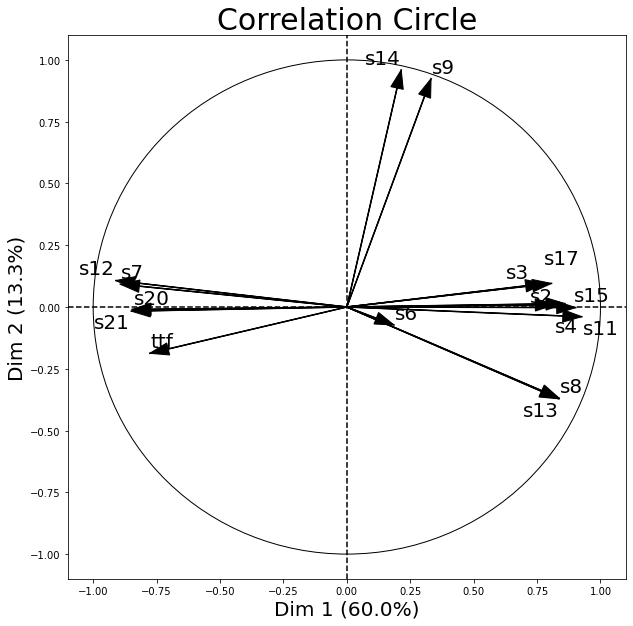

In [ ]:
X=datav
y = ['s12', 's7', 's21', 's20', 's6', 's14', 's9', 's13', 's8', 's3', 's17', 's2', 's15', 's4', 's11',"ttf"]

X_norm = X / X.std(axis=0) # Normalizing the feature columns is recommended



feature_names = ['s12', 's7', 's21', 's20', 's6', 's14', 's9', 's13', 's8', 's3', 's17', 's2', 's15', 's4', 's11',"ttf"]

figure, correlation_matrix = plot_pca_correlation_graph(X_norm, 
                                                        feature_names,
                                                        figure_axis_size=10)


In [ ]:

There is a very high correlation  between some features: (s14, s9), (s11, s4), (s12, s7),  (s4, s11), (s8,s13), (s7, s12)
This may hurt the performance of some ML algorithms.

## scatter plot 

In [ ]:
#scatterplot
sns.set()
cols = correl_featurs+["ttf"]
sns.pairplot(df_train_[cols], size = 5.5)
plt.show();

Output hidden; open in https://colab.research.google.com to view.

## normal probability

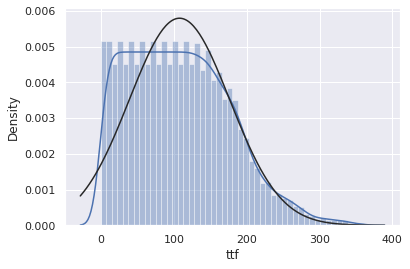

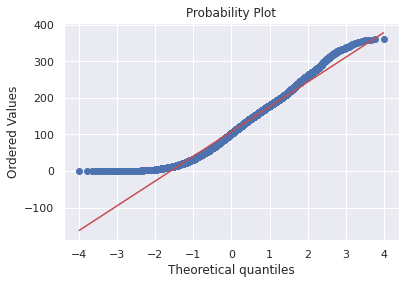

In [ ]:
#histogram and normal probability plot
sns.distplot(df_train_['ttf'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train_['ttf'], plot=plt)

## 3d plot

In [ ]:
!pip install plotly==4.14.3

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

In [ ]:


def plot3D(varr):
  fig = px.scatter_3d(df_train_, x = 'ttf', y= "cycle", z=varr,
                color='ttf', opacity = 0.8, size='ttf', size_max=30, hover_name=df_train_["ttf"],)
  np.random.seed(1)
  fig.show()

def histogram(varr):
  np.random.seed(1)

  x = df_train_[varr]

  fig = go.Figure(data=[go.Histogram(x=x)])
  fig.show()



In [ ]:
plot3D("s12")

In [ ]:
histogram("s12")

# Most features exhibit normal distribution which is likely improves models performance.

In [ ]:

# Create a function to explore the time series plot each sensor selecting random sample engines

def time_series(s):
    

    
    fig, axes = plt.subplots(2, 1, sharex=True, figsize = (15, 15))
    fig.suptitle(s + ' time series / cycle', fontsize=15)
    
    #np.random.seed(12345)
    select_engines = np.random.choice(range(1,101), 2, replace=False).tolist()
    
    for e_id in select_engines:
        df = df_train_[['cycle', s]][df_train_.id == e_id]
        i = select_engines.index(e_id)
        axes[i].plot(df['cycle'],df[s])
        axes[i].set_ylabel('engine ' + str(e_id))
        axes[i].set_xlabel('cycle')
        #axes[i].set_title('engine ' + str(e_id), loc='right')

    #plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

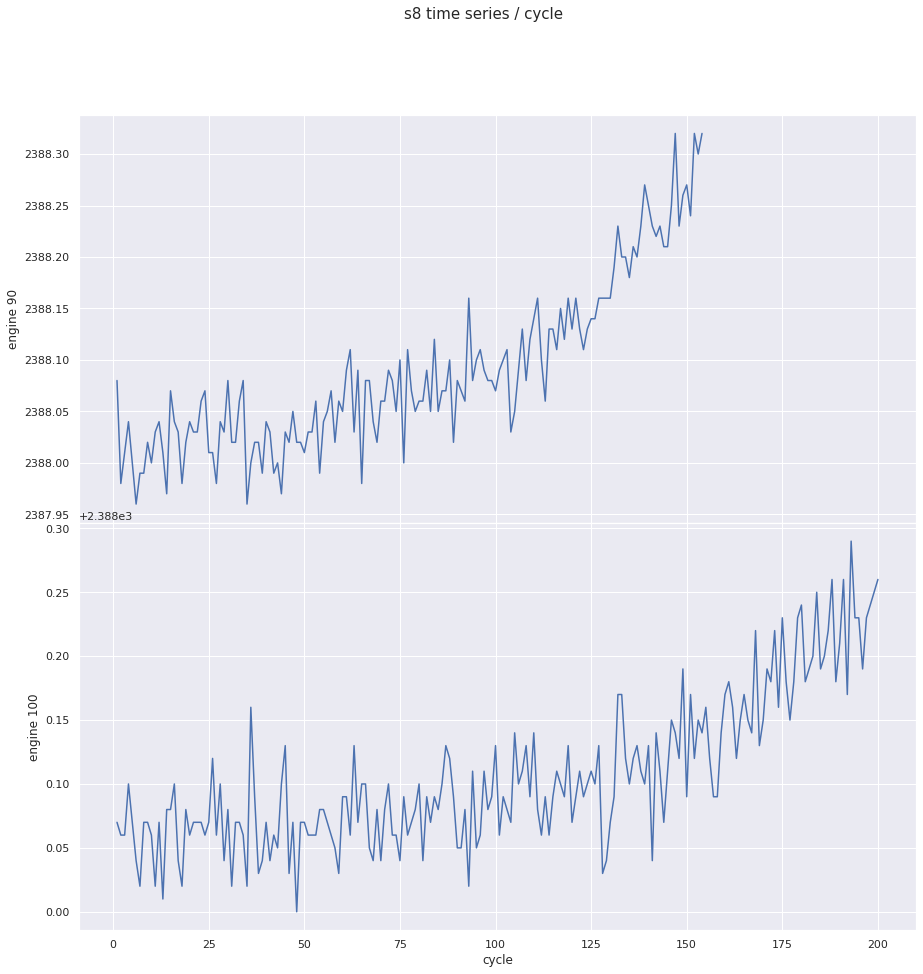

In [ ]:
time_series("s8")

In [ ]:
modeling

# modeling

## **regression**

In [ ]:
from sklearn import metrics 
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

In [ ]:

# original features
original_features= ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# original + extracted fetures
features_adxf = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'av1', 'av2', 'av3', 'av4', 'av5', 'av6', 'av7', 'av8', 'av9', 'av10', 'av11', 'av12', 'av13', 'av14', 'av15', 'av16', 'av17', 'av18', 'av19', 'av20', 'av21', 'sd1', 'sd2', 'sd3', 'sd4', 'sd5', 'sd6', 'sd7', 'sd8', 'sd9', 'sd10', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd16', 'sd17', 'sd18', 'sd19', 'sd20', 'sd21']

# features with low or no correlation with regression label
features_lowcr = ['setting3', 's1', 's10', 's18','s19','s16','s5', 'setting1', 'setting2']

# features that have correlation with regression label
features_corrl = ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20','s21']

In [ ]:
# best :========:>
features=['s12',  's21', 's20', 's6', 's14', 's13', 's3', 's17', 's2', 's15', 's11']


#(s14, s9), (s11, s4), (s12, s7),  (s4, s11), (s8,s13), (s7, s12)

In [ ]:
df_train_1=add_features(df_train_, 10)
df_test_1=add_features(df_test_, 10)

In [ ]:
df_test_

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def ScaleMinMax(data_num):
    scaler = MinMaxScaler()
    data_num_sc = pd.DataFrame(scaler.fit_transform(data_num), columns=data_num.columns)
    return data_num_sc

In [ ]:
df_train_.iloc[:,:-2]

In [ ]:
df_train_sc=ScaleMinMax(df_train_.iloc[:,:-2])
df_test_sc=ScaleMinMax(df_test_.iloc[:,:-2])

In [ ]:

X_train = df_train_[features]
y_train = df_train_['ttf']

X_test = df_test_[features]
y_test = df_test_['ttf']

In [ ]:
df_test_1

### linear regression

In [ ]:
#try linear regression

linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))


regr_metrics = {
                    'Root Mean Squared Error' : metrics.mean_squared_error(y_test, y_test_predict)**0.5,
                    'Mean Absolute Error' : metrics.mean_absolute_error(y_test, y_test_predict),
                    'R^2' : metrics.r2_score(y_test, y_test_predict),
                    'Explained Variance' : metrics.explained_variance_score(y_test, y_test_predict)
                }

#return reg_metrics
df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
df_regr_metrics.columns = ['Linear Regression']

df_regr_metrics

R^2 training: 0.574, R^2 test: 0.437


,Linear Regression
Root Mean Squared Error,31.166864
Mean Absolute Error,24.984404
R^2,0.437495
Explained Variance,0.686147


In [ ]:
# using  best features 
df_regr_metrics

,Linear Regression
Root Mean Squared Error,31.949775
Mean Absolute Error,25.536288
R^2,0.408879
Explained Variance,0.668094


In [ ]:
# using  features with del corr   the beeeeeeeeeeeeeeeeeeeeeeeest
df_regr_metrics

,Linear Regression
Root Mean Squared Error,31.166864
Mean Absolute Error,24.984404
R^2,0.437495
Explained Variance,0.686147


In [ ]:
# using all features
df_regr_metrics

,Linear Regression
Root Mean Squared Error,32.041095
Mean Absolute Error,25.591780
R^2,0.405495
Explained Variance,0.665297


In [ ]:
fet=X_test.columns
fig = go.Figure([go.Bar(x=fet, y=linreg.coef_)])
fig.show()

### LASSO

In [ ]:
#try LASSO

lasso = linear_model.Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

y_test_predict = lasso.predict(X_test)
y_train_predict = lasso.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))


lasso_metrics = {
                    'Root Mean Squared Error' : metrics.mean_squared_error(y_test, y_test_predict)**0.5,
                    'Mean Absolute Error' : metrics.mean_absolute_error(y_test, y_test_predict),
                    'R^2' : metrics.r2_score(y_test, y_test_predict),
                    'Explained Variance' : metrics.explained_variance_score(y_test, y_test_predict)
                }

#return reg_metrics
lasso_metrics = pd.DataFrame.from_dict(lasso_metrics, orient='index')
lasso_metrics.columns = ['LASSO']



lasso_metrics 

R^2 training: 0.574, R^2 test: 0.437


,LASSO
Root Mean Squared Error,31.173197
Mean Absolute Error,24.999953
R^2,0.437266
Explained Variance,0.686557


In [ ]:
fet=X_test.columns
fig = go.Figure([go.Bar(x=fet, y=lasso.coef_)])
fig.show()

### Polynomial Regression

In [ ]:
#try Polynomial Regression

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)


polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)

y_test_predict = polyreg.predict(X_test_poly)
y_train_predict = polyreg.predict(X_train_poly)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))



polyreg_metrics = {
                    'Root Mean Squared Error' : metrics.mean_squared_error(y_test, y_test_predict)**0.5,
                    'Mean Absolute Error' : metrics.mean_absolute_error(y_test, y_test_predict),
                    'R^2' : metrics.r2_score(y_test, y_test_predict),
                    'Explained Variance' : metrics.explained_variance_score(y_test, y_test_predict)
                }

#return reg_metrics
polyreg_metrics = pd.DataFrame.from_dict(polyreg_metrics, orient='index')
polyreg_metrics.columns = ['Polynomial Regression']




polyreg_metrics


R^2 training: 0.617, R^2 test: 0.452


,Polynomial Regression
Root Mean Squared Error,30.763026
Mean Absolute Error,23.695604
R^2,0.451977
Explained Variance,0.659619


In [ ]:
pd.concat([polyreg_metrics, lasso_metrics ,df_regr_metrics], axis=1)

,Polynomial Regression,LASSO,Linear Regression
Root Mean Squared Error,30.763026,31.173197,31.166864
Mean Absolute Error,23.695604,24.999953,24.984404
R^2,0.451977,0.437266,0.437495
Explained Variance,0.659619,0.686557,0.686147


In [ ]:
#Polynomial Regression has scored better than linear models

### Decision Tree

In [ ]:
#try Decision Tree regressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
#dtrg = DecisionTreeRegressor(max_depth=8, max_features=5, random_state=123) # selected features
dtrg = DecisionTreeRegressor(max_depth=7, random_state=123)
dtrg.fit(X_train, y_train)

y_test_predict = dtrg.predict(X_test)
y_train_predict = dtrg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))


dtrg_metrics = {
                    'Root Mean Squared Error' : metrics.mean_squared_error(y_test, y_test_predict)**0.5,
                    'Mean Absolute Error' : metrics.mean_absolute_error(y_test, y_test_predict),
                    'R^2' : metrics.r2_score(y_test, y_test_predict),
                    'Explained Variance' : metrics.explained_variance_score(y_test, y_test_predict)
                }

#return reg_metrics
dtrg_metrics = pd.DataFrame.from_dict(dtrg_metrics, orient='index')
dtrg_metrics.columns = ['Decision Tree Regression']
dtrg_metrics




R^2 training: 0.616, R^2 test: 0.360


,Decision Tree Regression
Root Mean Squared Error,33.242259
Mean Absolute Error,25.860526
R^2,0.360086
Explained Variance,0.610757


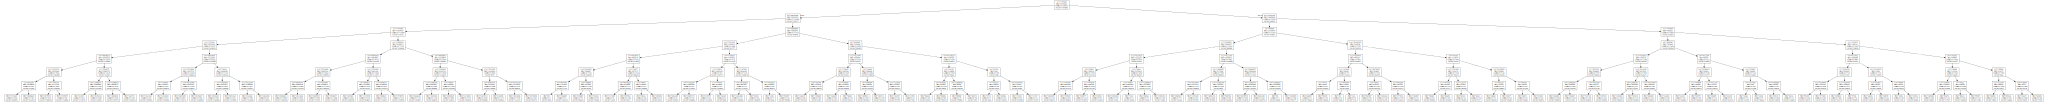

In [ ]:
# view the constructed decision tree

import graphviz

export_graphviz(dtrg, out_file="mytree.dot", feature_names=X_train.columns)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### Random Forest

In [ ]:
#try Random Forest

#rf = RandomForestRegressor(n_estimators=100, max_features=2, max_depth=4, n_jobs=-1, random_state=1) # selected features
rf = RandomForestRegressor(n_estimators=100, max_features=3, max_depth=4, n_jobs=-1, random_state=1) # original features
#rf = RandomForestRegressor(n_estimators=100, max_features=3, max_depth=7, n_jobs=-1, random_state=1) # orig + extrcted 

rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)
y_train_predict = rf.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))


rf_metrics = {
                    'Root Mean Squared Error' : metrics.mean_squared_error(y_test, y_test_predict)**0.5,
                    'Mean Absolute Error' : metrics.mean_absolute_error(y_test, y_test_predict),
                    'R^2' : metrics.r2_score(y_test, y_test_predict),
                    'Explained Variance' : metrics.explained_variance_score(y_test, y_test_predict)
                }

#return reg_metrics
rf_metrics = pd.DataFrame.from_dict(rf_metrics, orient='index')
rf_metrics.columns = ['Random Forest Regression']


rf_metrics

R^2 training: 0.590, R^2 test: 0.479


,Random Forest Regression
Root Mean Squared Error,29.991066
Mean Absolute Error,24.059974
R^2,0.479136
Explained Variance,0.725461


In [ ]:
# view predictions vs actual

rf_pred_dict = {
                'Actual' : y_test,
                'Prediction' : y_test_predict
            }
    
rf_pred = pd.DataFrame.from_dict(rf_pred_dict).T
rf_pred

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
Actual,112.000000,98.000000,69.000000,82.000000,91.000000,93.000000,91.000000,95.000000,111.000000,96.000000,97.000000,124.000000,95.00000,107.000000,83.000000,84.000000,50.000000,28.000000,87.000000,16.000000,57.000000,111.000000,113.000000,20.00000,145.000000,119.000000,66.000000,97.000000,90.000000,115.000000,8.000000,48.00000,106.000000,7.000000,11.000000,19.000000,21.000000,50.000000,142.000000,28.000000,...,21.000000,54.000000,72.000000,28.000000,128.000000,14.000000,77.000000,8.000000,121.000000,94.000000,118.000000,50.000000,131.000000,126.000000,113.000000,10.000000,34.000000,107.000000,63.000000,90.000000,8.000000,9.000000,137.000000,58.000000,118.000000,89.000000,116.000000,115.000000,136.000000,28.000000,38.00000,20.000000,85.000000,55.000000,128.000000,137.000000,82.000000,59.000000,117.000000,20.000000
Prediction,155.073874,118.244884,88.780246,96.618564,118.350684,125.990621,151.972321,82.153249,129.933354,131.227802,78.200509,105.369828,114.14379,104.532102,160.190182,136.912088,77.456917,83.802195,128.194821,28.099083,88.880815,148.112906,154.333983,48.47151,138.868492,139.726746,127.062009,118.318523,136.957438,112.327594,23.772971,89.29645,108.704627,13.076282,13.311113,23.245458,65.525282,51.163371,159.746904,25.971078,...,38.198079,76.722861,81.444384,60.001322,159.448258,25.184318,145.767212,20.109558,134.109895,109.332133,145.651378,93.450124,146.159688,118.785074,138.204406,14.838695,58.420711,163.390718,108.243437,103.879262,12.821787,13.277328,135.217928,69.867298,118.867282,110.034376,137.583393,140.958751,119.523301,50.194728,47.53669,18.963276,49.901012,59.027276,142.528145,167.545332,108.091076,111.405323,154.648307,40.193951


### results

In [ ]:
pd.concat([polyreg_metrics, lasso_metrics ,df_regr_metrics,dtrg_metrics,rf_metrics], axis=1)

,Polynomial Regression,LASSO,Linear Regression,Decision Tree Regression,Random Forest Regression
Root Mean Squared Error,30.763026,31.173197,31.166864,33.242259,29.991066
Mean Absolute Error,23.695604,24.999953,24.984404,25.860526,24.059974
R^2,0.451977,0.437266,0.437495,0.360086,0.479136
Explained Variance,0.659619,0.686557,0.686147,0.610757,0.725461


pour la partie régression les modèles Polynomial et Random Forest ont donné de meilleurs résultats que les modèles LASSO et la régression Linear . Random Forest a clairement surpassé les autres modèles avec un RMSE de 29.991066 cycles, c'est-à-dire que le modèle prédit le TTF dans une plage d'erreur moyenne de ± 29.991066 cycles.

## classification

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit,StratifiedKFold
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [ ]:

X_train = df_train_[features]
y_train = df_train_['label_classification']

X_test = df_test_[features]
y_test = df_test_['label_classification']

In [ ]:
def model_selection(X, y):
    iteration = 0
    k = 10
    models = {
        "K-nn": [],
        "Naive_Bayes": [],
        "Logistic_Regression": [],
        "SVM": [],
        "Random_Forest": [],
        "Ada-Boost": [],
        "XG-Boost": []
    }
    kf = KFold(n_splits=k)
    kf.get_n_splits(X)

    neigh = KNeighborsClassifier(n_neighbors=8)
    naive_b = GaussianNB()
    lr = LogisticRegression()
    SVM = svm.SVC()
    rf = RandomForestClassifier()
    for train_index, test_index in kf.split(X):
        #print("Iteration:", iteration)
        #iteration += 1
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]


        neigh.fit(X_train, y_train)
        models['K-nn'].append(neigh.score(X_test, y_test))

        naive_b = GaussianNB()
        naive_b.fit(X_train, y_train)
        models['Naive_Bayes'].append(naive_b.score(X_test, y_test))

        lr.fit(X_train, y_train)
        models['Logistic_Regression'].append(lr.score(X_test, y_test))

       #param_grid = {'C': [0.1, 1, 10, 100, 1000],  'gamma': [1, 0.1, 0.01, 0.001, ], 'kernel': ['rbf','poly','sigmoid']}  
    
        #grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
          
        # fitting the model for grid search 
        #grid.fit(X_train, y_train)
        SVM.fit(X_train, y_train)
        models['SVM'].append(SVM.score(X_test, y_test))


        rf.fit(X_train, y_train)
        models['Random_Forest'].append(rf.score(X_test, y_test))
        
        ada_b = AdaBoostClassifier(n_estimators=20, random_state=0)
        ada_b.fit(X_train, y_train)
        models['Ada-Boost'].append(ada_b.score(X_test, y_test))
        
        xgb_model = xgb.XGBClassifier()
        xgb_model.fit(X_train, y_train)
        models['XG-Boost'].append(xgb_model.score(X_test, y_test))

    model_evaluation_dict = {}
    for model in models.keys():
        model_evaluation_dict[model] = [np.mean(models[model])]
    df_evaluation = pd.DataFrame.from_dict(model_evaluation_dict)
    df_evaluation = df_evaluation.rename(index = {0 : 'Accuracy'})
    return df_evaluation

In [ ]:
model_selection(X_train,y_train)

,K-nn,Naive_Bayes,Logistic_Regression,SVM,Random_Forest,Ada-Boost,XG-Boost
Accuracy,0.937375,0.928698,0.950559,0.84974,0.957684,0.953855,0.958072


### Random forest

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 211, 222, 233, 244, 255, 266, 277, 288, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 23.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 244}

In [ ]:
rf_random.best_params_
base_model = RandomForestClassifier( )
base_model.fit(X_train, y_train)
print(base_model.score(X_test,y_test))

best_random = rf_random.best_estimator_
print(best_random.score(X_test,y_test))
#print(best_random.score(X_train, y_train))

0.92
0.92
1.0


In [ ]:
y_pred =  best_random.predict(X_test)

In [ ]:
binclass_metrics = {
                    'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                    'Precision' : metrics.precision_score(y_test, y_pred),
                    'Recall' : metrics.recall_score(y_test, y_pred),
                    'F1 Score' : metrics.f1_score(y_test, y_pred),
                    'ROC AUC' : metrics.roc_auc_score(y_test, y_score)
                    }

df_metrics = pd.DataFrame.from_dict(binclass_metrics, orient='index')
df_metrics.columns = ["Random forest"]  

In [ ]:
df_metrics

,Random forest
Accuracy,0.920000
Precision,0.947368
Recall,0.720000
F1 Score,0.818182
ROC AUC,0.978667


In [ ]:
print('-----------------------------------------------------------')
print("Random forest", '\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred))
print('\nClassification Report:')
print(metrics.classification_report(y_test, y_pred))

-----------------------------------------------------------
Random forest 

Confusion Matrix:
[[74  1]
 [ 7 18]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95        75
           1       0.95      0.72      0.82        25

    accuracy                           0.92       100
   macro avg       0.93      0.85      0.88       100
weighted avg       0.92      0.92      0.92       100



In [ ]:
y_score = best_random.predict_proba(X_test)[:,1]

In [ ]:
y_score

In [ ]:

precision, recall, thresh_prc = metrics.precision_recall_curve(y_test, y_score)

thresh_prc = np.append(thresh_prc,1)

engines_prc = []  
for thr in thresh_prc:  
    engines_prc.append((y_score >= thr).mean())

engines_prc = np.array(engines_prc)

prc_thresh = {
                'Threshold' : thresh_prc,
                'Precision' : precision,
                'Recall' : recall,
                'Que' : engines_prc
              }

df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)

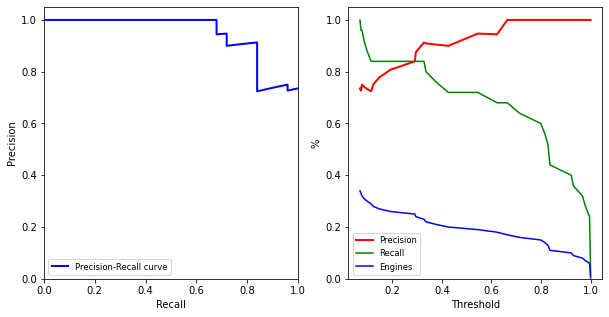

In [ ]:
fig, (ax2, ax4) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False )
fig.set_size_inches(10,5)


ax2.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc="lower left", fontsize='small')


ax4.plot(thresh_prc, precision, color='red', lw=2, label='Precision')  
ax4.plot(thresh_prc, recall, color='green',label='Recall') 
ax4.plot(thresh_prc, engines_prc, color='blue',label='Engines') 
ax4.set_ylim([0.0, 1.05])
ax4.set_xlabel('Threshold')  
ax4.set_ylabel('%')
ax4.legend(loc='lower left', fontsize='small')

### SVM

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC 
from sklearn.metrics import classification_report

In [ ]:

from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, ],  
              'gamma': [1, 0.1, 0.01, 0.001, ], 
              'kernel': ['rbf','sigmoid']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.850, total=  19.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.8s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.850, total=  20.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.1s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.850, total=  20.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.850, total=  20.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.850, total=  20.1s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=0.1, gamma=1, kernel=sigmoid, score=0.850, total=   2.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=0.1, gamma=1, kernel=sigmoid, score=0.850, total=   2.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=0.1, gamma=1, kernel=sigmoid, score=0.850, total=   2.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=0.1, gamma=1, kernel=sigmoid, score=0.850, total=   2.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 14.6min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
# print best parameter after tuning 
print(grid.best_params_) 

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
print(grid.best_params_) 

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:

grid_predictions = grid.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        75
           1       0.90      0.76      0.83        25

    accuracy                           0.92       100
   macro avg       0.91      0.87      0.89       100
weighted avg       0.92      0.92      0.92       100



In [ ]:
grid.score(X_train,y_train)

In [ ]:
binclass_metrics = {
                    'Accuracy' : metrics.accuracy_score(y_test, grid_predictions),
                    'Precision' : metrics.precision_score(y_test, grid_predictions),
                    'Recall' : metrics.recall_score(y_test, grid_predictions),
                    'F1 Score' : metrics.f1_score(y_test, grid_predictions),
                    'ROC AUC' : metrics.roc_auc_score(y_test, grid_predictions)
                    }

df_metrics_svm = pd.DataFrame.from_dict(binclass_metrics, orient='index')
df_metrics_svm.columns = ["SVM"]  

In [ ]:
df_metrics_svm

,SVM
Accuracy,0.920000
Precision,0.904762
Recall,0.760000
F1 Score,0.826087
ROC AUC,0.866667


In [ ]:
print('-----------------------------------------------------------')
print("SVM", '\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, grid_predictions))
print('\nClassification Report:')
print(metrics.classification_report(y_test, grid_predictions))

-----------------------------------------------------------
SVM 

Confusion Matrix:
[[73  2]
 [ 6 19]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95        75
           1       0.90      0.76      0.83        25

    accuracy                           0.92       100
   macro avg       0.91      0.87      0.89       100
weighted avg       0.92      0.92      0.92       100



### Logistic Regression

In [ ]:
#Logistic regression
from sklearn.linear_model import LogisticRegression

In [ ]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, ],  
              'gamma': [1, 0.1, 0.01, 0.001, ], 
              'kernel': ['rbf','sigmoid']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

In [ ]:
clf = LogisticRegression()
grid_values = {'penalty': [ 'l2','l1' ],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'recall')
grid_clf_acc.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [ ]:
# print best parameter after tuning 
print(grid_clf_acc.best_params_) 

{'C': 10, 'penalty': 'l2'}


In [ ]:

grid_predictions_LG = grid_clf_acc.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions_LG)) 

              precision    recall  f1-score   support

           0       0.89      0.99      0.94        75
           1       0.94      0.64      0.76        25

    accuracy                           0.90       100
   macro avg       0.92      0.81      0.85       100
weighted avg       0.90      0.90      0.89       100



In [ ]:
binclass_metrics = {
                    'Accuracy' : metrics.accuracy_score(y_test, grid_predictions_LG),
                    'Precision' : metrics.precision_score(y_test, grid_predictions_LG),
                    'Recall' : metrics.recall_score(y_test, grid_predictions_LG),
                    'F1 Score' : metrics.f1_score(y_test, grid_predictions_LG),
                    'ROC AUC' : metrics.roc_auc_score(y_test, grid_predictions_LG)
                    }

df_metrics_LG = pd.DataFrame.from_dict(binclass_metrics, orient='index')
df_metrics_LG.columns = ["Logistic Regression"]  

In [ ]:
df_metrics_LG

,Logistic Regression
Accuracy,0.900000
Precision,0.941176
Recall,0.640000
F1 Score,0.761905
ROC AUC,0.813333


In [ ]:
print('-----------------------------------------------------------')
print("df_metrics_LG", '\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, grid_predictions_LG))
print('\nClassification Report:')
print(metrics.classification_report(y_test, grid_predictions_LG))

-----------------------------------------------------------
df_metrics_LG 

Confusion Matrix:
[[74  1]
 [ 9 16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94        75
           1       0.94      0.64      0.76        25

    accuracy                           0.90       100
   macro avg       0.92      0.81      0.85       100
weighted avg       0.90      0.90      0.89       100



### KNN

Text(0, 0.5, 'Erreur')

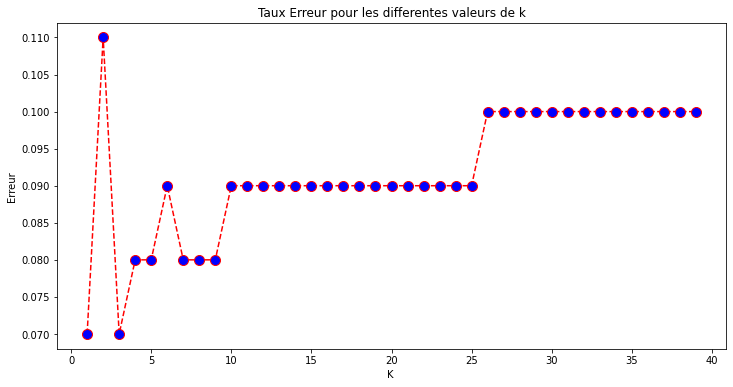

In [ ]:
error = []
# Calculer l'erreur pour k entre 1 et 40 
#Pour chaque itération, l'erreur moyenne pour les valeurs prédites 
#de l'ensemble de test est calculée et sauvegardée ds la liste Erreur.
for i in range(1, 40):
    knn = KNeighborsClassifier(i)
    knn_model = knn.fit(X_train, y_train)
    pred_i = knn_model.predict(X_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Taux Erreur pour les differentes valeurs de k')
plt.xlabel('K ')
plt.ylabel('Erreur')


In [ ]:
  knn = KNeighborsClassifier()



  parameters = {'n_neighbors':[3,4,5,6,7,8,9,10],
                'leaf_size':[1,3,5],
                'algorithm':['auto', 'kd_tree'],
                'n_jobs':[-1]}

  #Fit the model
  modelknn = GridSearchCV(knn, param_grid=parameters)
  modelknn.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['auto', 'kd_tree'],
                         'leaf_size': [1, 3, 5], 'n_jobs': [-1],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# print best parameter after tuning 
print(modelknn.best_params_) 

{'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 5}


In [ ]:

grid_predictions_KNN = modelknn.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions_KNN)) 

In [ ]:
binclass_metrics = {
                    'Accuracy' : metrics.accuracy_score(y_test, grid_predictions_KNN),
                    'Precision' : metrics.precision_score(y_test, grid_predictions_KNN),
                    'Recall' : metrics.recall_score(y_test, grid_predictions_KNN),
                    'F1 Score' : metrics.f1_score(y_test, grid_predictions_KNN),
                    'ROC AUC' : metrics.roc_auc_score(y_test, grid_predictions_KNN)
                    }

df_metrics_KNN = pd.DataFrame.from_dict(binclass_metrics, orient='index')
df_metrics_KNN.columns = ["KNN"]  

In [ ]:
df_metrics_KNN

,KNN
Accuracy,0.920000
Precision,0.869565
Recall,0.800000
F1 Score,0.833333
ROC AUC,0.880000


In [ ]:
print('-----------------------------------------------------------')
print("df_metrics_KNN", '\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, grid_predictions_KNN))
print('\nClassification Report:')
print(metrics.classification_report(y_test, grid_predictions_KNN))

-----------------------------------------------------------
df_metrics_KNN 

Confusion Matrix:
[[72  3]
 [ 5 20]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        75
           1       0.87      0.80      0.83        25

    accuracy                           0.92       100
   macro avg       0.90      0.88      0.89       100
weighted avg       0.92      0.92      0.92       100



### results

In [ ]:
pd.concat([ df_metrics ,df_metrics_svm,df_metrics_LG,df_metrics_KNN], axis=1)

,Random forest,SVM,Logistic Regression,KNN
Accuracy,0.920000,0.920000,0.900000,0.920000
Precision,0.947368,0.904762,0.941176,0.869565
Recall,0.720000,0.760000,0.640000,0.800000
F1 Score,0.818182,0.826087,0.761905,0.833333
ROC AUC,0.978667,0.866667,0.813333,0.880000


## Clustering 

### KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA, KernelPCA

In [ ]:


def elbow_method(X):
  distortions = []
  for i in range(1, 11):
      km = KMeans(
          n_clusters=i, init='random',
          n_init=10, max_iter=300,
          tol=1e-04, random_state=0
      )
      km.fit(X)
      distortions.append(km.inertia_)

  # plot
  plt.plot(range(1, 11), distortions, marker='o')
  plt.xlabel('Number of clusters')
  plt.ylabel('Distortion')
  plt.show()


In [ ]:
def ScaleMinMax(data_num):
    scaler = MinMaxScaler()
    data_num_sc = pd.DataFrame(scaler.fit_transform(data_num), columns=data_num.columns)
    return data_num_sc

def ScalerStandard(data_num):
    scaler = StandardScaler()
    data_num_sc = pd.DataFrame(scaler.fit_transform(data_num), columns=data_num.columns)
    return data_num_sc

def ScalerRobust(data_num):
    scaler = RobustScaler()
    data_num_sc = pd.DataFrame(scaler.fit_transform(data_num), columns=data_num.columns)
    return data_num_sc


def ScaleMinMax2(data_num):
    scaler = MinMaxScaler()
    data_num_sc = pd.DataFrame(scaler.fit_transform(data_num), columns=data_num.columns)
    data_num_sc.set_index(data_num.index, inplace = True)
    return data_num_sc    


def ScalerStandard2(data_num):
    scaler = StandardScaler()
    data_num_sc = pd.DataFrame(scaler.fit_transform(data_num), columns=data_num.columns)
    data_num_sc.set_index(data_num.index, inplace = True)
    return data_num_sc

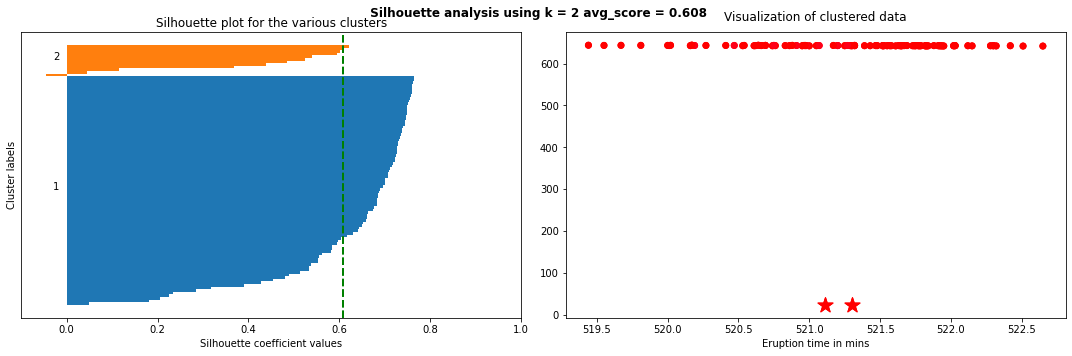

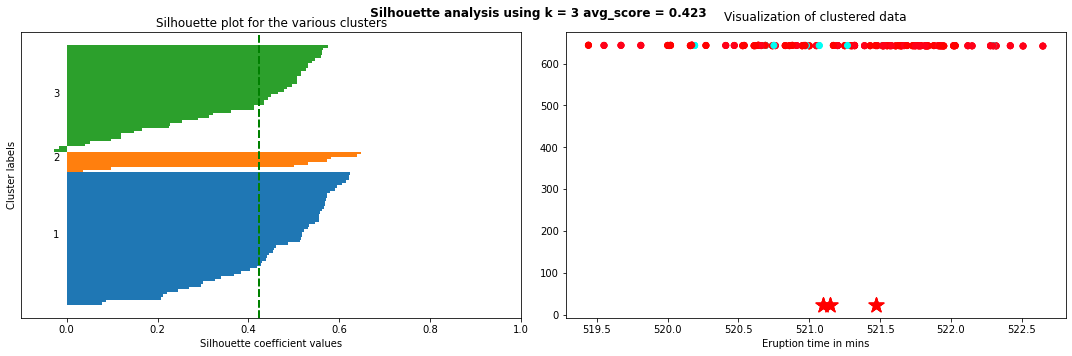

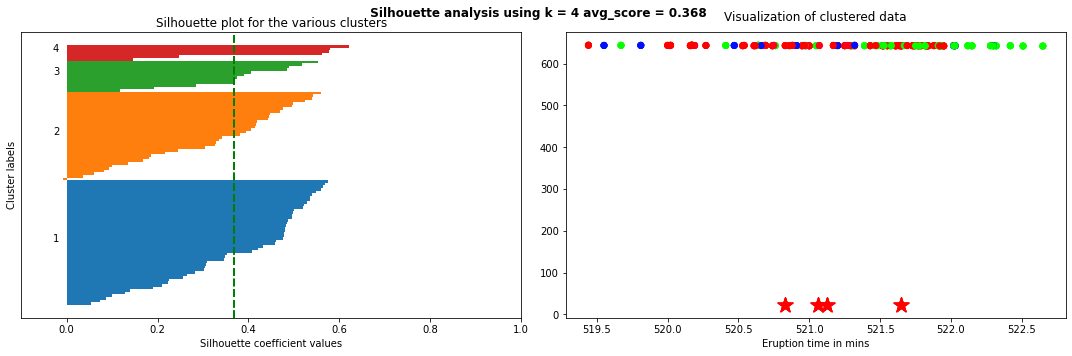

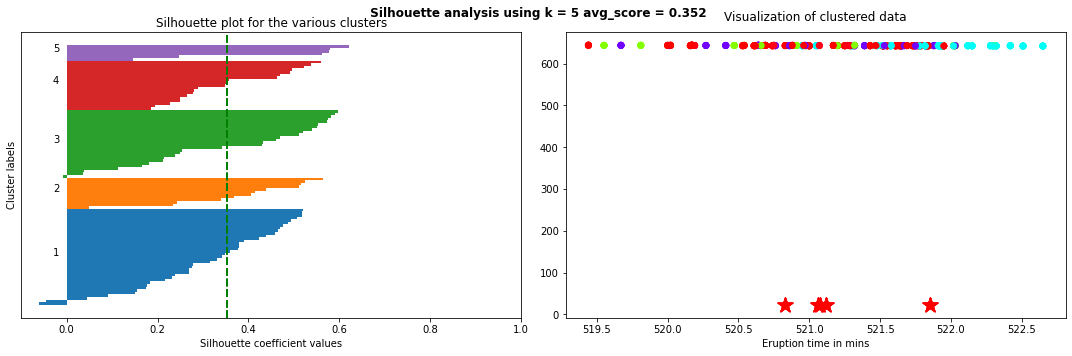

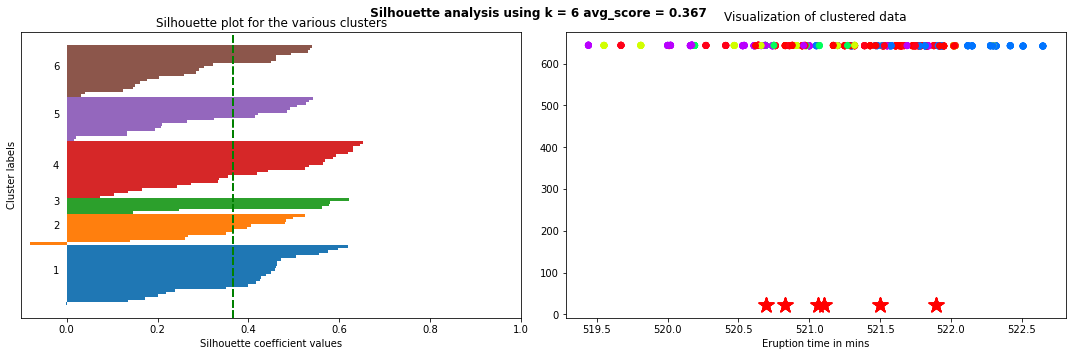

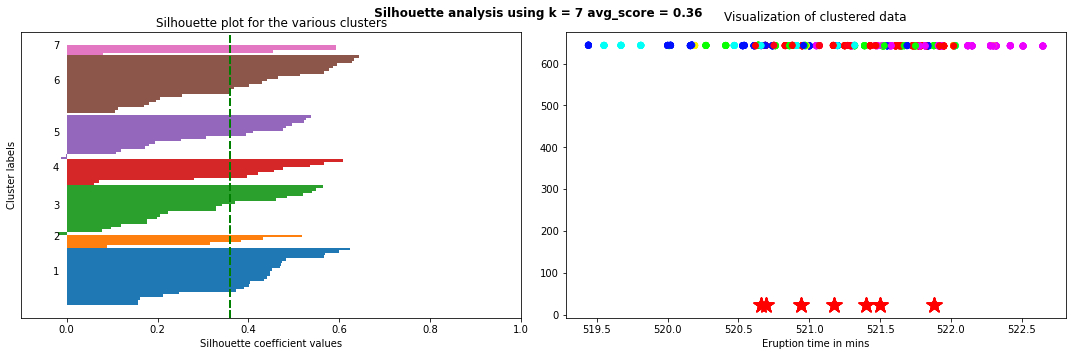

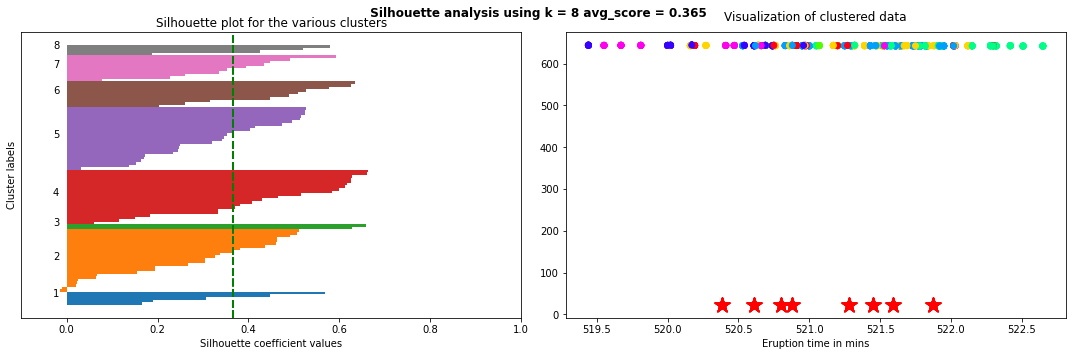

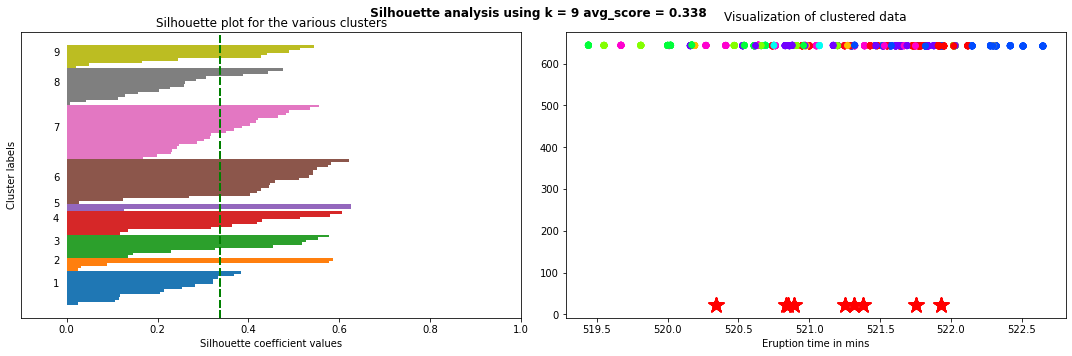

In [ ]:
for i,k in enumerate([2,3,4,5,6,7,8,9]):
  fig, ax = plt.subplots(1,2,figsize=(15,5))
  km = KMeans(n_clusters=k, init='k-means++' ,n_init=20, max_iter=100 ,random_state=42)# Run the kmeans algorithm
  y_predict = km.fit_predict(X_test)
  centroids  = km.cluster_centers_
  # get silhouette
  silhouette_vals = silhouette_samples(X_test,y_predict)
      #silhouette_vals
  # silhouette plot
  y_ticks = []
  y_lower = y_upper = 0
  for i,cluster in enumerate(np.unique(y_predict)):
    cluster_silhouette_vals = silhouette_vals[y_predict ==cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)

    ax[0].barh(range(y_lower,y_upper),
    cluster_silhouette_vals,height =1);
    ax[0].text(-0.03,(y_lower+y_upper)/2,str(i+1))
    y_lower += len(cluster_silhouette_vals)
        
    # Get the average silhouette score 
    avg_score = np.mean(silhouette_vals)
    ax[0].axvline(avg_score,linestyle ='--',
    linewidth =2,color = 'green')
    ax[0].set_yticks([])
    ax[0].set_xlim([-0.1, 1])
    ax[0].set_xlabel('Silhouette coefficient values')
    ax[0].set_ylabel('Cluster labels')
    ax[0].set_title('Silhouette plot for the various clusters');
    # scatter plot of data colored with labels
    ax[1].scatter(X_test["s12"],X_test["s2"] , c = y_predict ,cmap='hsv')
  
    ax[1].scatter(centroids[:,0],centroids[:,1],
    marker = '*' , c= 'r',s =250);
    ax[1].set_xlabel('Eruption time in mins')
    #ax[1].set_ylabel('Waiting time to next eruption')
    ax[1].set_title('Visualization of clustered data', y=1.02)

    plt.tight_layout()

    plt.suptitle(f' Silhouette analysis using k = {k} avg_score = {  round(avg_score,3)}',fontsize=12,fontweight = 'semibold')
  

In [ ]:
X_test_sc=ScaleMinMax(X_test)

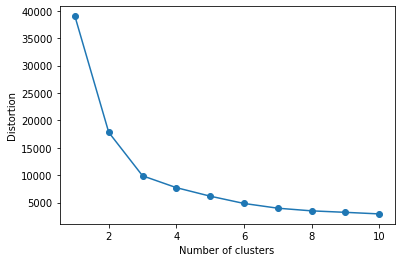

In [ ]:
elbow_method(X_test)

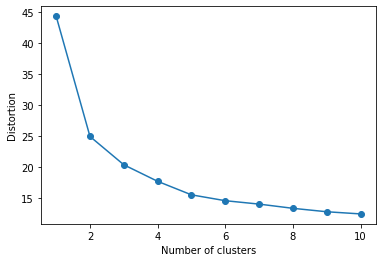

In [ ]:
elbow_method(X_test_sc)

In [ ]:
#L’appel à metrics.adjusted_rand_score() compare le partitionnement obtenu par la classification automatique
#(étiquettes de groupe de kmeans.labels_) avec le partitionnement correspondant aux groupes définis au départ
#(étiquettes de la dernière colonne de data).

In [ ]:
def KMENAS(data,target):
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(data);
    #print(metrics.silhouette_score(np.reshape(list(target), (1000,-1)),kmeans.labels_))
    plt.figure('K-means with 2 clusters', figsize=(15,10))
    plt.scatter(data['s12'], data['s2'], c=kmeans.labels_)
    plt.show()
    print(adjusted_rand_score(kmeans.labels_,target))
    return pd.crosstab(target,kmeans.labels_)

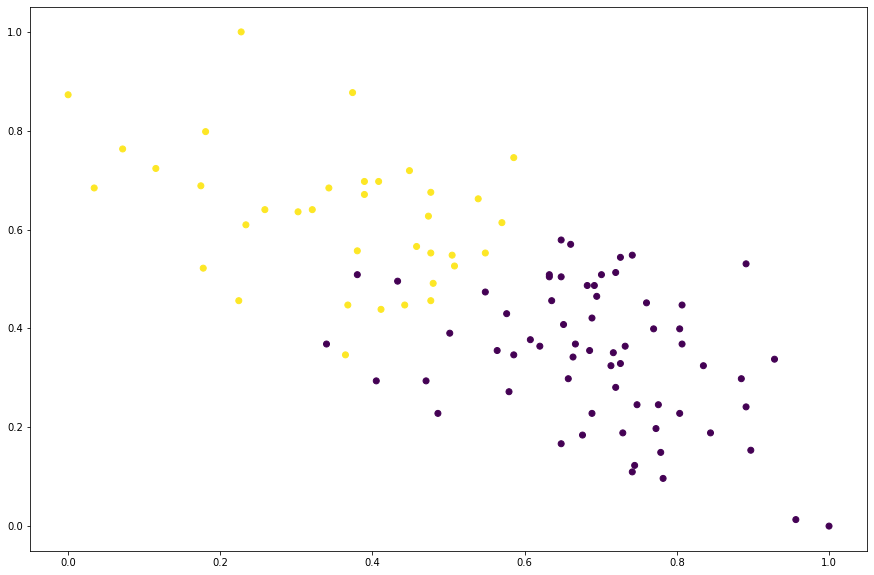

0.5977063020658224


col_0,0,1
label_classification,,
0,64,11
1,0,25


In [ ]:
data_num_sc = ScaleMinMax(X_test)

KMENAS(pd.DataFrame(data_num_sc),y_test)

In [ ]:
def KMENAS_pca(data,target):
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(data);
    #print(metrics.silhouette_score(np.reshape(list(target), (1000,-1)),kmeans.labels_))
  
    print(adjusted_rand_score(kmeans.labels_,target))
    return pd.crosstab(target,kmeans.labels_)

In [ ]:
data_num_red = ScaleMinMax(X_test)
reduced_data = PCA(n_components=2).fit_transform(data_num_red)

KMENAS_pca(pd.DataFrame(reduced_data),y_test)

0.5672292388510115


col_0,0,1
label_classification,,
0,63,12
1,0,25


In [ ]:
X_test

In [ ]:
data_num_sc = ScalerStandard(X_test)

svd = TruncatedSVD(n_components=2)
reduced_data_svd = svd.fit_transform(data_num_sc)
KMENAS_pca(pd.DataFrame(reduced_data_svd),y_test)

0.5672292388510115


col_0,0,1
label_classification,,
0,63,12
1,0,25


### CAH

In [ ]:
#librairies pour la CAH 
from matplotlib import pyplot as plt 
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from sklearn.cluster import AgglomerativeClustering

In [ ]:

def CAH(data):
    matrice = linkage(data,method='ward', metric='euclidean')
    plt.figure(figsize=(20,20))
    plt.title('Dendogramme')
    dendrogram(matrice)
    plt.show()
    cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
    cluster.fit_predict(data)
    print(adjusted_rand_score(y_test,cluster.fit_predict(data)))
    pd.crosstab(y_test,cluster.fit_predict(data))
    return pd.crosstab(y_test,cluster.fit_predict(data))

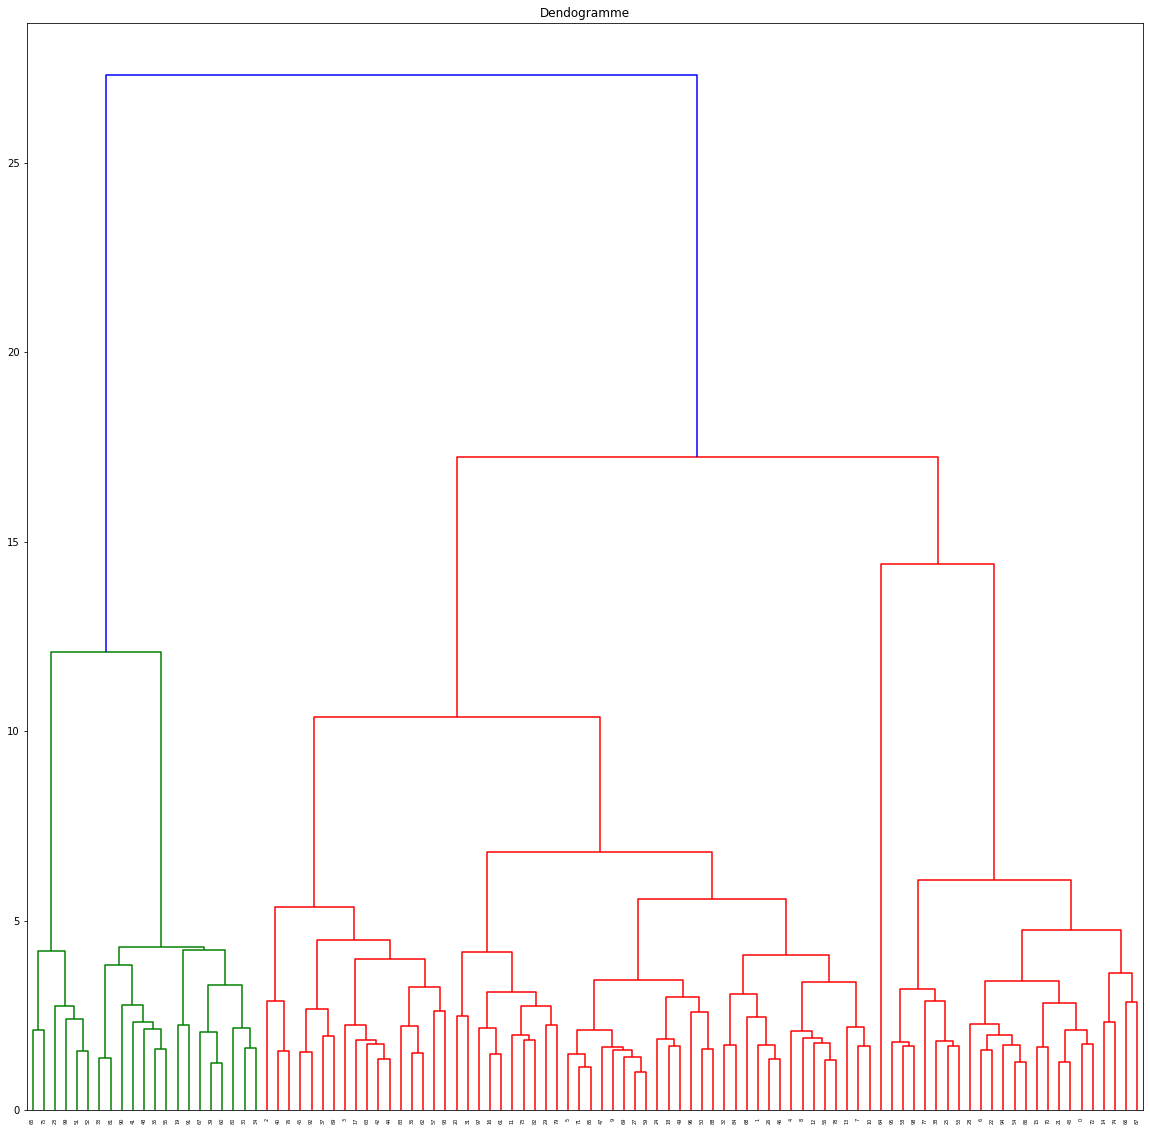

0.7523254421334185


col_0,0,1
label_classification,,
0,74,1
1,5,20


In [ ]:
data_num_sc = ScalerStandard(X_test)

CAH(data_num_sc)

## Deep Learning Classification

   with the Keras

In [ ]:

X_train = df_train_[features]
y_train = df_train_['label_classification']

X_test = df_test_[features]
y_test = df_test_['label_classification']

In [ ]:

import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [ ]:
X_train.shape

(20631, 11)

In [ ]:

model = Sequential()
model.add(Dense(20, input_dim=11, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 20)                240       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 21        
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.utils.vis_utils import plot_model

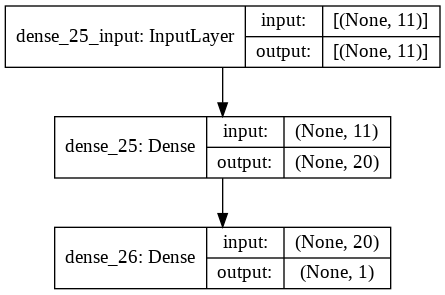

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# fit the model on all data
model.fit(X_train, y_train, verbose=1, epochs=100)

Epoch 1/100
645/645 [==============================] - 1s 1ms/step - loss: 0.4746
Epoch 2/100
645/645 [==============================] - 1s 1ms/step - loss: 0.5306
Epoch 3/100
645/645 [==============================] - 1s 1ms/step - loss: 0.5342
Epoch 4/100
645/645 [==============================] - 1s 1ms/step - loss: 0.4935
Epoch 5/100
645/645 [==============================] - 1s 1ms/step - loss: 0.5524
Epoch 6/100
645/645 [==============================] - 1s 1ms/step - loss: 0.5487
Epoch 7/100
645/645 [==============================] - 1s 1ms/step - loss: 0.4906
Epoch 8/100
645/645 [==============================] - 1s 1ms/step - loss: 0.4714
Epoch 9/100
645/645 [==============================] - 1s 1ms/step - loss: 0.5090
Epoch 10/100
645/645 [==============================] - 1s 1ms/step - loss: 0.4956
Epoch 11/100
645/645 [==============================] - 1s 1ms/step - loss: 0.4947
Epoch 12/100
645/645 [==============================] - 1s 1ms/step - loss: 0.4738
Epoch 13/100


In [ ]:
from sklearn.metrics import accuracy_score
	# make a prediction on the test set
yhat = model.predict(X_test)
# round probabilities to class labels
yhat = yhat.round()
# calculate accuracy
acc = accuracy_score(y_test, yhat)
# store result
print('accuracy_score : %.3f' % acc)

accuracy_score : 0.840
